# MLClass. "Прикладной анализ данных"
# Модуль "Машинное обучение с помощью Python"
<img src="../img/mlclass_logo.jpg" height="240" width="240">
## Автор материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий
Материал распространяется на условиях лицензии <a href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-Share Alike 4.0</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Урок 6. Нейронные сети. Бустинг. Смешивание алгоритмов. Стекинг.
## Часть 6.  3-кратный стекинг для набора данных Titanic. ROC AUC 

<a href="https://www.kaggle.com/c/titanic">Соревнование</a>.

Подключаем библиотеки

In [1]:
import pandas as pd
import numpy as np
%pylab inline
figsize(12, 8)
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from scipy.stats.stats import pearsonr 
from load_titanic_with_features import load_titanic

Populating the interactive namespace from numpy and matplotlib


Считываем данные

In [37]:
%%time
X_train, y, X_test, = map(np.array, 
                          load_titanic("../data/titanic_train.csv",
                                   "../data/titanic_test.csv"))

CPU times: user 156 ms, sys: 11.4 ms, total: 168 ms
Wall time: 176 ms


Разобьем обучающую выборку на валидационную и проверочную (holdout) части.

In [38]:
X_valid, X_holdout, y_valid, y_holdout = train_test_split(X_train, y, 
                                                          train_size=0.8, 
                                                          random_state=13)

Для kNN отшкалируем данные

In [39]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)
X_valid_scaled, X_holdout_scaled, y_valid_scaled, y_holdout_scaled = \
    train_test_split(X_train_scaled, y, train_size=0.8, random_state=13)

In [44]:
shape(X_valid), shape(X_holdout)

((712, 8), (179, 8))

Напишем функцию для вывода результатов в виде, готовом для посылки на Kaggle.

In [6]:
def write_to_file(predicted_labels, filename, init_index=892):
    predicted_df = pd.DataFrame(predicted_labels,
                index = np.arange(init_index, 
                                  init_index + \
                                  X_test.shape[0]),
                columns=["Survived"])
    predicted_df.to_csv(filename, 
                        index_label="PassengerId")

## kNN

In [7]:
%%time

res = []

neighb = np.arange(1, 300)

for n in neighb:
    scores = cross_val_score(KNeighborsClassifier(n_neighbors=n), 
                            X_valid_scaled, y_valid, 
                            scoring="roc_auc",
                            cv=3)
    res.append(np.mean(scores))

CPU times: user 8.29 s, sys: 239 ms, total: 8.52 s
Wall time: 8.51 s


(0.85473422145214151, 17)

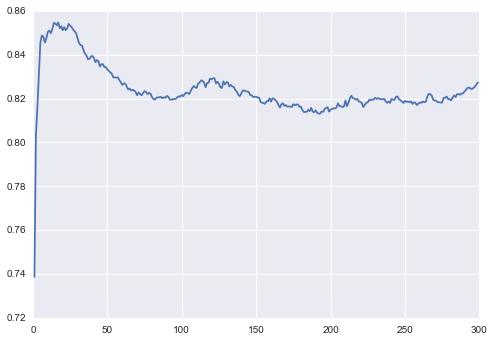

In [8]:
plot(neighb, res)
knn_valid_auc = max(res)
knn_valid_auc, neighb[np.argmax(res)]

In [9]:
thresholds = np.arange(-2.0, 2.0, 0.025)
results = []

knn = KNeighborsClassifier(n_neighbors=17)

for thres in thresholds:
    folds = StratifiedKFold(y_valid, n_folds=5, random_state=42)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid_scaled[train_index, :], \
                          X_valid_scaled[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        knn.fit(x_train, y_train)
        y_pred = (1 - knn.predict_proba(x_test)[:,0]
                                   >= thres).astype(int)
        if(len(np.unique(y_pred)) > 1):
            scores.append(roc_auc_score(y_pred, y_test))
        else:
            scores.append(0)
    results.append(np.mean(scores))

(0.83995350666229596, 0.64999999999999059)

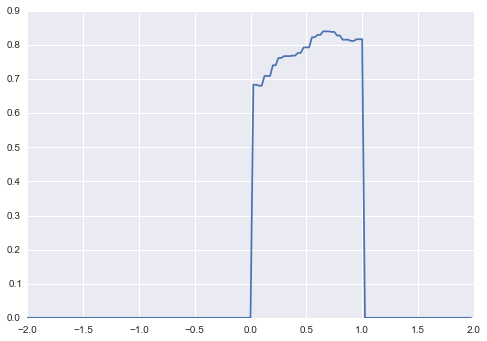

In [10]:
plot(thresholds, results)
knn_valid_thres_auc = max(results)
knn_valid_thres_auc, thresholds[np.argmax(results)]

**Сохраним предсказания модели в процессе 3-кратной кросс-валидации и проверим модель на X_holdout**

In [11]:
knn = KNeighborsClassifier(n_neighbors=17)
knn_predictions = []

folds = StratifiedKFold(y_valid, n_folds=3, random_state=42)
for train_index, test_index in folds:
    x_train, x_test = X_valid_scaled[train_index, :], \
                          X_valid_scaled[test_index, :]
    y_train, y_test = y_valid[train_index], y_valid[test_index]
    knn.fit(x_train, y_train)
    y_pred = (1 - knn.predict_proba(x_test)[:,0] - 0.65)
    knn_predictions.extend(y_pred)

In [12]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_valid_scaled, y_valid_scaled)
roc_auc_score((1 - knn.predict_proba(X_holdout_scaled)[:,0] 
               - 0.65 >= 0).astype(int), y_holdout)
                       

0.82576005230467464

## Линейный SVM

In [13]:
%%time

res = []

degrees = np.arange(-5., 5., 0.1)

for deg in degrees:
    scores = cross_val_score(LinearSVC(C=10 ** deg), 
                            X_valid, y_valid, 
                            scoring="roc_auc", cv=3)
    res.append(np.mean(scores))

CPU times: user 6.3 s, sys: 7.83 ms, total: 6.3 s
Wall time: 6.31 s


(0.84364775565502426, -1.8000000000000114)

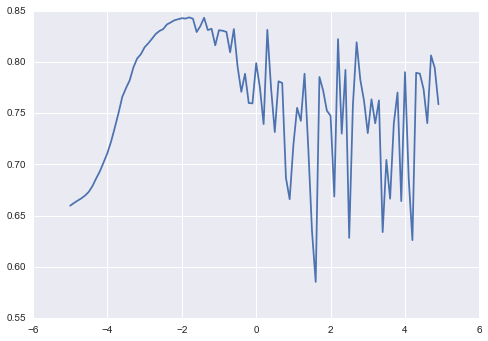

In [15]:
plot(degrees, res)
lin_svc_valid_auc = max(res)
lin_svc_valid_auc, degrees[list(res).index(max(res))]

Ищем значения параметра C в более узком диапазоне.

In [16]:
%%time

res = []

degrees = np.arange(-2, -0.5, 0.05)

for deg in degrees:
    scores = cross_val_score(LinearSVC(C=10 ** deg), 
                            X_valid, y_valid, 
                            scoring="roc_auc", cv=3)
    res.append(np.mean(scores))

CPU times: user 2.2 s, sys: 4.17 ms, total: 2.2 s
Wall time: 2.2 s


(0.84620666973197023, -1.6499999999999997)

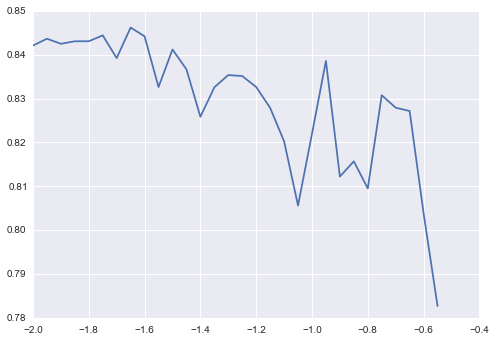

In [17]:
plot(degrees, res)
lin_svc_valid_auc = max(res)
lin_svc_valid_auc, degrees[list(res).index(max(res))]

**Подберем порог отсечения, максимизирующий AUC в процессе кросс-валидации**

In [18]:
thresholds = np.arange(-2.0, 2.0, 0.025)
results = []

lin_svc = LinearSVC(C=10 ** -1.65)

for thres in thresholds:
    folds = StratifiedKFold(y_valid, n_folds=5, random_state=42)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid[train_index, :], \
                          X_valid[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        lin_svc.fit(x_train, y_train)
        y_pred = (lin_svc.decision_function(x_test) 
                                   >= thres).astype(int)
        if len(np.unique(y_pred)) > 1:
            scores.append(roc_auc_score(y_pred, y_test))
        else:
            scores.append(0)
    results.append(np.mean(scores))

(0.83116279845718244, 0.29999999999999183)

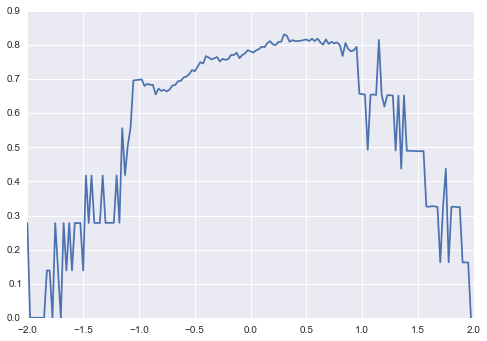

In [19]:
plot(thresholds, results)
lin_svc_valid_thres_auc = max(results)
lin_svc_valid_thres_auc, thresholds[np.argmax(results)]

**Сохраним предсказания модели в процессе 3-кратной кросс-валидации и проверим модель на X_holdout**

In [20]:
lin_svc = LinearSVC(C=10 ** -1.65)
lin_svc_predictions = []

folds = StratifiedKFold(y_valid, n_folds=3, random_state=42)

for train_index, test_index in folds:
    x_train, x_test = X_valid[train_index, :], \
                          X_valid[test_index, :]
    y_train, y_test = y_valid[train_index], y_valid[test_index]
    lin_svc.fit(x_train, y_train)
    y_pred = lin_svc.decision_function(x_test) - 0.3
    lin_svc_predictions.extend(y_pred)

In [21]:
lin_svc = LinearSVC(C=10 ** -1.65)
lin_svc.fit(X_valid, y_valid)
roc_auc_score((lin_svc.decision_function(X_holdout) 
               - 0.3 > 0).astype(int), y_holdout) 

0.8202131043256996

## Случайный лес

In [22]:
%%time

forest_params = {'n_estimators': [10, 50, 100],
                 'max_depth': list(range(1, 10, 2)),
                 'min_samples_leaf': list(range(1, 10, 2))}

locally_best_forest = GridSearchCV(RandomForestClassifier(),
                                 forest_params,
                                 verbose=True, n_jobs=4, cv=3,
                                  scoring="roc_auc")
locally_best_forest.fit(X_valid, y_valid)

res = locally_best_forest.grid_scores_

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 225 out of 225 | elapsed:    4.8s finished


CPU times: user 783 ms, sys: 140 ms, total: 923 ms
Wall time: 5.04 s


(0.86967177752691394,
 {'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 10},
 51)

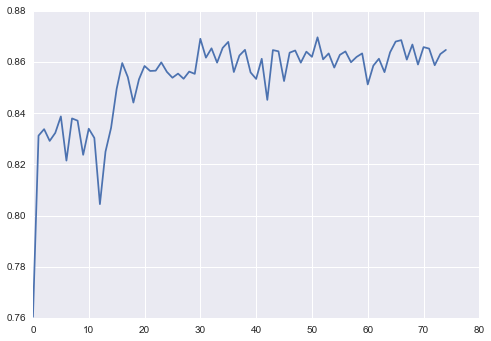

In [23]:
scores, params = [r[1] for r in res], [r[0] for r in res]
rf_valid_auc = max(scores)
plot(range(len(params)), scores)
rf_valid_auc, params[np.argmax(scores)], np.argmax(scores)

**Подберите порог отсечения, максимизирующий accuracy в процессе кросс-валидации**

In [24]:
thresholds = np.arange(0, 1.0, 0.025)
results = []

rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf=5,
                            n_estimators=10)

for thres in thresholds:
    folds = StratifiedKFold(y_valid, n_folds=5, random_state=42)
    scores = []
    for train_index, test_index in folds:
        x_train, x_test = X_valid[train_index, :], \
                          X_valid[test_index, :]
        y_train, y_test = y_valid[train_index], y_valid[test_index]
        rf.fit(x_train, y_train)
        y_pred = (1 - rf.predict_proba(x_test)[:,0] \
                                   >= thres).astype(int)
        if len(np.unique(y_pred)) > 1:
            scores.append(roc_auc_score(y_pred, y_test))
        else:
            scores.append(0)
    results.append(np.mean(scores))

(0.84324324285446828, 0.67500000000000004)

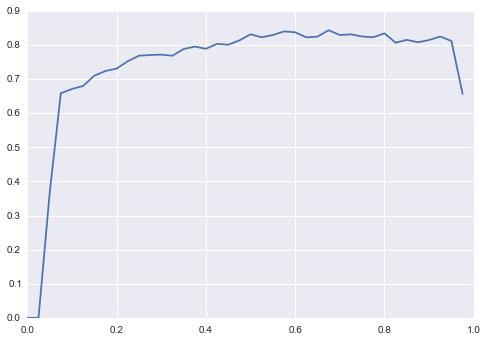

In [25]:
plot(thresholds, results)
rf_valid_auc_thres = max(results)
rf_valid_auc_thres, thresholds[np.argmax(results)]

**Сохраним предсказания модели в процессе 3-кратной кросс-валидации и проверим модель на X_holdout**

In [26]:
rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf=5,
                            n_estimators=10)
rf_predictions = []

folds = StratifiedKFold(y_valid, n_folds=3, random_state=42)

for train_index, test_index in folds:
    x_train, x_test = X_valid[train_index, :], \
                          X_valid[test_index, :]
    y_train, y_test = y_valid[train_index], y_valid[test_index]
    rf.fit(x_train, y_train)
    y_pred = 1 - rf.predict_proba(x_test)[:,0] - 0.675
    rf_predictions.extend(y_pred)

In [27]:
rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf=5,
                            n_estimators=10)
rf.fit(X_valid, y_valid)

roc_auc_score((1 - rf.predict_proba(X_holdout)[:,0] 
                             - 0.675 >= 0).astype(int), y_holdout)

0.81109933373712895

## Составим матрицу предсказаний 3 моделей и обучим на ней RandomForestRegressor

In [49]:
level2_train = np.vstack([knn_predictions, lin_svc_predictions,
                         rf_predictions]).T

In [50]:
level2_train.shape

(712, 3)

In [51]:
level2_train[:10]

array([[-0.12058824, -0.58209736, -0.21414551],
       [-0.59117647, -1.04814399, -0.6299358 ],
       [-0.59117647, -1.07244149, -0.5405145 ],
       [-0.17941176, -0.07174014, -0.26871184],
       [-0.53235294, -1.48634354, -0.41910173],
       [-0.53235294, -1.06385807, -0.51511022],
       [-0.65      , -0.97416634, -0.58983162],
       [-0.47352941, -0.84480246, -0.57557137],
       [ 0.11470588,  0.17483197,  0.31388889],
       [-0.12058824, -0.16666405, -0.24547295]])

In [52]:
level2_rf = RandomForestRegressor(n_estimators=100, max_depth=2)

In [53]:
level2_rf.fit(level2_train, y_valid)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [54]:
knn = KNeighborsClassifier(n_neighbors=17)
lin_svc = LinearSVC(C=10 ** -1.65)
rf = RandomForestClassifier(max_depth=7,
                            min_samples_leaf=5,
                            n_estimators=10)

knn.fit(X_valid_scaled, y_valid_scaled)
lin_svc.fit(X_valid, y_valid)
rf.fit(X_valid, y_valid)

ho_level2_train = np.vstack([1 - knn.predict_proba(X_holdout_scaled)[:,0] 
                             - 0.65,
                            lin_svc.decision_function(X_holdout) - 0.3,
                            1 - rf.predict_proba(X_holdout)[:,0] 
                             - 0.675]).T

In [55]:
stacking_holdout_pred = (level2_rf.predict(ho_level2_train) >= 0.5).astype(int)
roc_auc_score(stacking_holdout_pred, y_holdout)

0.84320557491289194